In [1]:
metadata_path = "../data/db2/MFD_metadatas.csv"
max_days = 365 * 3

In [2]:
from mandrillage.dataset import read_dataset, MandrillImageDataset
dataset = read_dataset(
    metadata_path,
    filter_dob_error=True,
    filter_certainty=False,
    max_age=max_days,
    max_dob_error=10,
    sex=None
)

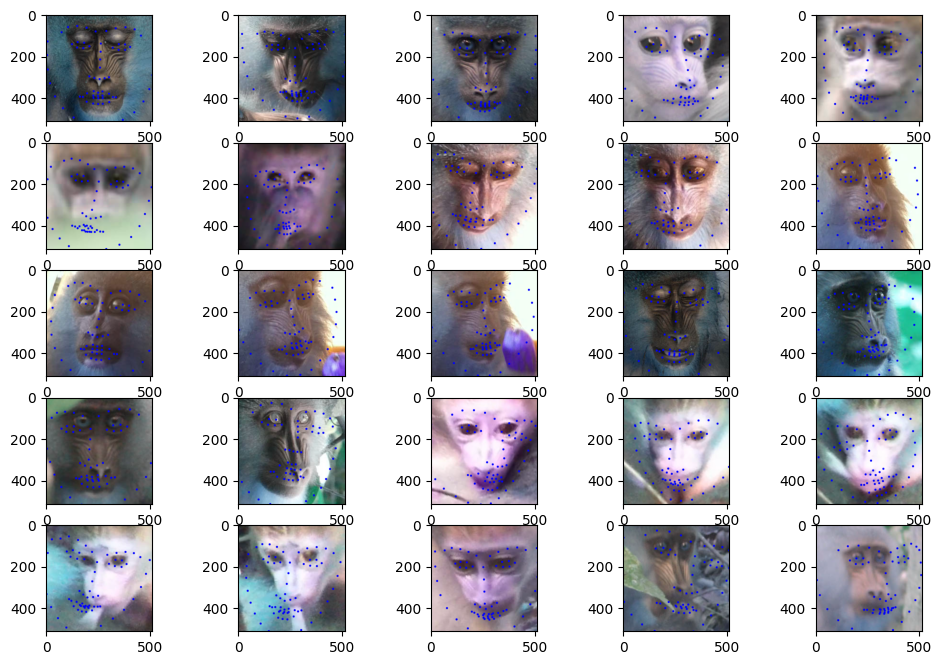

In [3]:
dataset_reader = MandrillImageDataset("../data/db2/Images",
        dataset,
        img_size=(224, 224),
        in_mem=False,
        max_days=1,
        individuals_ids=[],
        max_nbins=12,
        training=False)

from matplotlib import pyplot as plt
  
def to_float(str_value):
    if "," in str_value:
        str_value = str_value.replace(",", ".")
    return float(str_value)

def f2i(f_value, scale=1):
    return int(f_value * scale)

def get_row_coords(row, x, y, scale_x, scale_y):
    return f2i(to_float(row[x]), scale_x), f2i(to_float(row[y]), scale_y)

import cv2
from imutils import face_utils

def display_row(row, ax, detector, predictor):
    photo = dataset_reader.load_photo(row, normalize=False)
    photo = cv2.resize(photo, (512, 512), interpolation=cv2.INTER_AREA)
    width, height = photo.shape[0], photo.shape[1]
    
    shape = predictor(photo, dlib.rectangle(0, 0, width, height))
    shape = face_utils.shape_to_np(shape)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(photo, (x, y), 5, (0, 0, 255), -1)
    

    # top_left = get_row_coords(row, "left_top_x", "left_top_y", width, height)
    # bottom_left = get_row_coords(row, "left_bottom_x", "left_bottom_y", width, height)
    # top_right = get_row_coords(row, "right_top_x", "right_top_y", width, height)
    # bottom_right = get_row_coords(row, "right_bottom_x", "right_bottom_y", width, height)    
    
    # ax.plot([top_left[0], bottom_left[0]], [top_left[1], bottom_left[1]], color="red", linewidth=3)
    # ax.plot([bottom_left[0], bottom_right[0]], [bottom_left[1], bottom_right[1]], color="red", linewidth=3)
    # ax.plot([bottom_right[0], top_right[0]], [bottom_right[1], top_right[1]], color="red", linewidth=3)
    # ax.plot([top_right[0], top_left[0]], [top_right[1], top_left[1]], color="red", linewidth=3)

    

    ax.imshow(photo)

import dlib
shape_predictor_path = "../data/db2/shape_predictor_68_face_landmarks_GTX.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

nrows = 5
ncols = 5
n_images = nrows * ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(12,8))
for i in range(n_images):
    row = dataset.iloc[i*10]
    fig_row = i // ncols
    fig_col = i % ncols
    
    ax = axs[fig_row, fig_col] 
    display_row(row, ax, detector, predictor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


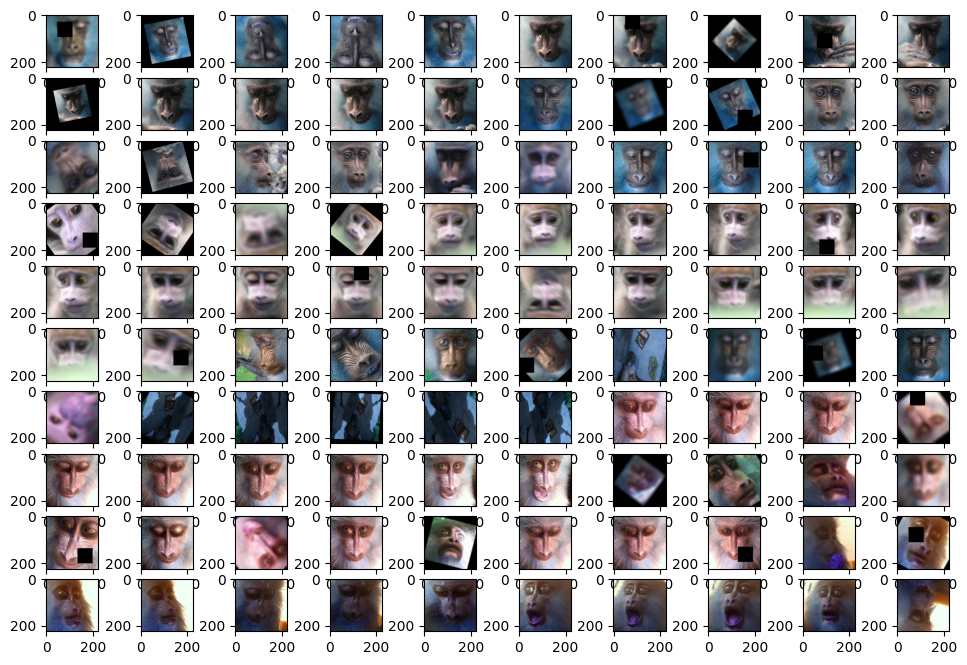

In [4]:
from mandrillage.dataset import AugmentedDataset
import numpy as np

augmented = AugmentedDataset(dataset_reader)

nrows = 10
ncols = 10
n_images = nrows * ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(12,8))
for i in range(n_images):
    x, y = augmented[i]
    fig_row = i // ncols
    fig_col = i % ncols
    
    ax = axs[fig_row, fig_col] 
    ax.imshow(np.moveaxis(x, 0, -1))